In [1]:
from eolearn.core import EOWorkflow, Dependency
from eolearn.core import FeatureType

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio.features
import rasterio.transform
import datetime
import os
from pathlib import Path
from math import ceil

from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
# testing
import scipy.stats as stats

In [4]:
from tqdm import tqdm_notebook as tqdm

In [5]:
from eolearn.core import LoadFromDisk, SaveToDisk, AddFeature, EOPatch, EOTask, FeatureTypeSet, FeatureType, LinearWorkflow, EOExecutor
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature
from eolearn.features import LinearInterpolation

In [6]:
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask

/Users/markbogataj/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [151]:
buffer = -5
fraction_size = 0.05 # koliksen del podatkov vzame
spatial = False
window = 1 # če je 1 je per pixel, drugače pa glede na velikost okna
interpolation_range = [8]#2,4,8,16,32,64,128] # [2,4,8] # [16, 32] # [2,4,8,16,32]
mask_valid = 'VALID_DATA' # L1C_VALID changed from VALID_DATA
#resampled_range = ('2017-01-01', '2017-09-30', interpolation)
drop_classes = [1,3,4,5,8,14,16,18,19,21]
class_labels = set(list(range(1,26))) - set(drop_classes)
MAIN_FOLDER = Path('/Volumes/Seagate_drive') # spremenis na path do podatkov zip-a
DATA_FOLDER = os.path.join(MAIN_FOLDER, 'original')
DATA_LIST = os.listdir(DATA_FOLDER)
#OUTPUT_FOLDER = os.path.join(MAIN_FOLDER, 'interpolation-{}days'.format(interpolation))

In [152]:
actual_fraction = fraction_size/(window*window)
print(actual_fraction, actual_fraction*(window**2))

0.05 0.05


In [153]:
non_empty_patches =[]
for name in DATA_LIST:
    if(name == '.DS_Store'):
        continue
    else:
        eopatch = EOPatch.load(os.path.join(DATA_FOLDER, name), lazy_loading=True)
        if len(eopatch.data)!=0:
            non_empty_patches.append(name)
DATA_LIST = non_empty_patches

In [155]:
# DATA_LIST = [DATA_LIST[1]]
DATA_LIST = ['eopatch_88_col-7_row-7', 'eopatch_89_col-7_row-8', 'eopatch_90_col-7_row-9',
            'eopatch_100_col-8_row-7', 'eopatch_101_col-8_row-8', 'eopatch_102_col-8_row-9',
            'eopatch_111_col-9_row-7', 'eopatch_112_col-9_row-8', 'eopatch_113_col-9_row-9']
print(len(DATA_LIST))
print(DATA_LIST)
# DATA_LIST = DATA_LIST[:15]
# DATA_LIST

9
['eopatch_88_col-7_row-7', 'eopatch_89_col-7_row-8', 'eopatch_90_col-7_row-9', 'eopatch_100_col-8_row-7', 'eopatch_101_col-8_row-8', 'eopatch_102_col-8_row-9', 'eopatch_111_col-9_row-7', 'eopatch_112_col-9_row-8', 'eopatch_113_col-9_row-9']


In [11]:
eopatch = EOPatch.load(os.path.join('/Volumes/Seagate_drive/original/', DATA_LIST[0]))
eopatch

EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_ID', 'SIFINFOGIS', 'SIFRA_KMRS', 'geometry'], length=4485, crs=EPSG:32633)
    LPIS_2017_org: geopandas.GeoDataFrame(columns=['KM

In [156]:
class bufferPolys(EOTask):
    
    def __init__(self, features, buffer):
        self.feature_type, self.feature_name = features[0], features[1]
        self.buffer = buffer
    
    def execute(self, eop):
        # crops = eopatch.vector_timeless['LPIS_2017']
        crops = eop[self.feature_type][self.feature_name]
        crops_buffered = crops.copy(deep=True)
        # make buffer = -5
        crops_buffered.geometry = crops.buffer(self.buffer)
        crops_buffered = crops_buffered[~crops_buffered.is_empty]
        crops_buffered['SIFRA_KMRS'] = pd.to_numeric(crops_buffered['SIFRA_KMRS'])

        eop.add_feature(FeatureType.VECTOR_TIMELESS, 'LPIS_buffered', crops_buffered)
        
        return eop

In [157]:
class VectorToRasterMultiple(EOTask):
    """
    Task burns into one of the EOPatch's features geo-referenced shapes given in provided Geopandas DataFrame.

    :param feature: A tuple of feature type and feature name, e.g. (FeatureType.MASK, 'cloud_mask')
    :type feature: (FeatureType, str)
    :param vector_data: Vector data
    :type vector_data: geopandas.GeoDataFrame
    :param raster_value: Value of raster pixels which are contained inside of vector polygons
    :type raster_value: int or float
    :param raster_shape: Can be a tuple in form of (height, width) of an existing feature from which the shape will be
                            taken e.g. (FeatureType.MASK, 'IS_DATA')
    :type raster_shape: (int, int) or (FeatureType, str)
    :param raster_dtype: `numpy` data type of the obtained raster array
    :type raster_dtype: numpy.dtype
    :param no_data_value: Value of raster pixels which are outside of vector polygons
    :type no_data_value: int or float
    :param kwargs: arguments passed to rasterio.features.rasterize
    """
    def __init__(self, feature, vector_feature, raster_value, raster_shape, raster_dtype=np.uint8, no_data_value=0,
                 **kwargs):
        self.feature_type, self.feature_name = next(iter(self._parse_features(feature)))
        self.vector_feature = vector_feature
        self.raster_value = raster_value
        self.raster_shape = raster_shape
        self.raster_dtype = raster_dtype
        self.no_data_value = no_data_value
        self.kwargs = kwargs

    def _get_submap(self, eopatch):
        """
        Returns a new geopandas dataframe with same structure as original one (columns) except that
        it contains only polygons that are contained within the given bbox.

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch
        :rtype: EOPatch
        """
#         bbox_poly = eopatch.bbox.get_geometry()
        bbox_poly = eopatch.bbox.geometry
        vector_data = eopatch[self.vector_feature[0]][self.vector_feature[1]]
        
        vector_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        
        vector_data.geometry = vector_data.geometry.buffer(0)
        vetor_data = vector_data[vector_data.geometry.is_valid]
        vetor_data = vector_data[~vector_data.geometry.is_empty]
        
        filtered_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        pairs = []
        for idx, row in filtered_data.iterrows():
            pairs.append((row.geometry, row[self.raster_value]))

        return pairs

    def _get_shape(self, eopatch):
        if isinstance(self.raster_shape, (tuple, list)) and len(self.raster_shape) == 2:
            if isinstance(self.raster_shape[0], int) and isinstance(self.raster_shape[1], int):
                return self.raster_shape

            feature_type, feature_name = next(self._parse_features(self.raster_shape)(eopatch))
            return eopatch.get_spatial_dimension(feature_type, feature_name)

        raise ValueError('Could not determine shape of the raster image')

    def execute(self, eopatch):
        """ Execute function which adds new vector layer to the EOPatch

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch with added vector layer
        :rtype: EOPatch
        """
        # print(eopatch)
        bbox_map = self._get_submap(eopatch)
        height, width = self._get_shape(eopatch)
        data_transform = rasterio.transform.from_bounds(*eopatch.bbox, width=width, height=height)

        if self.feature_name in eopatch[self.feature_type]:
            raster = eopatch[self.feature_type][self.feature_name].squeeze()
        else:
            raster = np.ones((height, width), dtype=self.raster_dtype) * self.no_data_value

        if len(bbox_map):
            rasterio.features.rasterize(bbox_map, out=raster,
                                        transform=data_transform,
                                        dtype=self.raster_dtype,
                                        **self.kwargs)

        eopatch[self.feature_type][self.feature_name] = raster[..., np.newaxis]

        return eopatch

In [158]:
class VectorToRasterMultiple2(EOTask):
    """
    Task burns into one of the EOPatch's features geo-referenced shapes given in provided Geopandas DataFrame.

    :param feature: A tuple of feature type and feature name, e.g. (FeatureType.MASK, 'cloud_mask')
    :type feature: (FeatureType, str)
    :param vector_data: Vector data
    :type vector_data: geopandas.GeoDataFrame
    :param raster_value: Value of raster pixels which are contained inside of vector polygons
    :type raster_value: int or float
    :param raster_shape: Can be a tuple in form of (height, width) of an existing feature from which the shape will be
                            taken e.g. (FeatureType.MASK, 'IS_DATA')
    :type raster_shape: (int, int) or (FeatureType, str)
    :param raster_dtype: `numpy` data type of the obtained raster array
    :type raster_dtype: numpy.dtype
    :param no_data_value: Value of raster pixels which are outside of vector polygons
    :type no_data_value: int or float
    :param kwargs: arguments passed to rasterio.features.rasterize
    """
    def __init__(self, feature, vector_feature, raster_value, raster_shape, raster_dtype=np.uint8, no_data_value=0,
                 **kwargs):
        self.feature_type, self.feature_name = next(iter(self._parse_features(feature)))
        self.vector_feature = vector_feature
        self.raster_value = raster_value
        self.raster_shape = raster_shape
        self.raster_dtype = raster_dtype
        self.no_data_value = no_data_value
        self.kwargs = kwargs

    def _get_submap(self, eopatch):
        """
        Returns a new geopandas dataframe with same structure as original one (columns) except that
        it contains only polygons that are contained within the given bbox.

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch
        :rtype: EOPatch
        """
#         bbox_poly = eopatch.bbox.get_geometry()
        bbox_poly = eopatch.bbox.geometry
        vector_data = eopatch[self.vector_feature[0]][self.vector_feature[1]]
        
        vector_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        
        vector_data.geometry = vector_data.geometry.buffer(0)
        vetor_data = vector_data[vector_data.geometry.is_valid]
        vetor_data = vector_data[~vector_data.geometry.is_empty]
        
        filtered_data = vector_data[vector_data.geometry.intersects(bbox_poly)].copy(deep=True)
        pairs = []
        for idx, row in filtered_data.iterrows():
            pairs.append((row.geometry, row[self.raster_value]))

        return pairs

    def execute(self, eopatch):
        """ Execute function which adds new vector layer to the EOPatch

        :param eopatch: input EOPatch
        :type eopatch: EOPatch
        :return: New EOPatch with added vector layer
        :rtype: EOPatch
        """
        # print(eopatch)
        bbox_map = self._get_submap(eopatch)
        height = eopatch[FeatureType.MASK]['IS_DATA'].shape[1] * 10
        width = eopatch[FeatureType.MASK]['IS_DATA'].shape[2] * 10
        
        data_transform = rasterio.transform.from_bounds(*eopatch.bbox, width=width, height=height)

        if self.feature_name in eopatch[self.feature_type]:
            raster = eopatch[self.feature_type][self.feature_name].squeeze()
        else:
            raster = np.ones((height, width), dtype=self.raster_dtype) * self.no_data_value

        if len(bbox_map):
            rasterio.features.rasterize(bbox_map, out=raster,
                                        transform=data_transform,
                                        dtype=self.raster_dtype,
                                        **self.kwargs)

        eopatch[self.feature_type][self.feature_name] = raster[..., np.newaxis]

        return eopatch

In [159]:
class select_bands(EOTask):
    
    def __init__(self, feature, new_feature_name, features):
        self.feature_type, self.feature_name = feature[0], feature[1]
        self.new_feature_name = new_feature_name
        self.features = features
    
    def execute(self, eop):
        bands = eop[self.feature_type][self.feature_name]
        bands_new = bands[:, :, :, self.features]
        eop.add_feature(self.feature_type, self.new_feature_name, bands_new)
        
        return eop
    
class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch
    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch

In [160]:
def undersampleMajority(mask, rows, cols, fraction):
    sampled = np.random.rand(len(rows)) > (1.0 - fraction*2) # increase sample size by 2 to later reduce by 50%
    
    sampled_classes = mask[rows[sampled], cols[sampled]]
    # checking the distribution of mapped classes
    sampled_classes = np.array([get_numeric_group(get_group_id(str(x).zfill(3), lpis_to_group), group_to_numeric) for x in sampled_classes])
    values = np.unique(sampled_classes, return_counts=True)
    number_of_2 = values[1][np.where(values[0]==2)[0]][0]
    
    for location, x in enumerate(sampled_classes):
        if x in drop_classes:
            sampled_classes[location] = 0
            
    clean = sampled_classes==0
    sampled_classes = sampled_classes[~clean]
    
    sampled2 = np.random.rand(number_of_2) > (1.0 - 1/6) # we want only 1/6 of them all
        
    sub_sample = np.where(sampled_classes==2)[0][~sampled2]
    sampled[np.where(sampled==True)[0][sub_sample]]=False
    
    #sampled_classes = mask[rows[sampled], cols[sampled]]
    #sampled_classes = np.array([get_numeric_group(get_group_id(str(x).zfill(3), lpis_to_group), group_to_numeric) for x in sampled_classes])
    #values = np.unique(sampled_classes, return_counts=True)
    #distrib = np.round(values[1]/sum(values[1]), 6)
    #fig = plt.figure(figsize=(15, 15))
    #plt.bar(values[0], distrib, align='center')
    #plt.xticks(values[0], values[0]);
    
    return sampled

def sample(mask, rows, cols, fraction):
    sampled = np.random.rand(len(rows)) > (1.0 - fraction)
    return sampled

class SampleValid(EOTask):
    """
    The task samples pixels with a value in given timeless feature different from no valid data value.
    """

    def __init__(self, feature, fraction=1.0, no_data_value=0, sample_features=...):
        """ Task to sample pixels from a reference timeless raster mask, excluding a no valid data value

        :param feature:  Reference feature used to select points to be sampled
        :param fraction: Fraction of valid points to be sampled
        :param no_data_value: Value of non-valid points to be ignored
        """
        self.feature_type, self.feature_name, self.new_feature_name = next(
            self._parse_features(feature, new_names=True,
                                 default_feature_type=FeatureType.MASK_TIMELESS,
                                 allowed_feature_types={FeatureType.MASK_TIMELESS},
                                 rename_function='{}_SAMPLED'.format)())
        self.fraction = fraction
        self.no_data_value = no_data_value
        self.sample_features = self._parse_features(sample_features)

    def execute(self, in_eopatch, eopatch_folder, OUTPUT_FOLDER, seed=None):
        eopatch = in_eopatch.__copy__()
        #print(eopatch_folder)
        mask = eopatch[self.feature_type][self.feature_name].squeeze()

        if mask.ndim != 2:
            raise ValueError('Invalid shape of sampling reference map.')
        
        rows, cols = np.where(mask != self.no_data_value)
        sampling_file = Path(os.path.join(OUTPUT_FOLDER, eopatch_folder, 'sampling.npy'))
        
        np.random.seed(seed)
        if not os.path.exists(os.path.join(OUTPUT_FOLDER, eopatch_folder)):
            os.makedirs(os.path.join(OUTPUT_FOLDER, eopatch_folder))
            
        if sampling_file.is_file():
            sampled = np.load(sampling_file)
            if not(round(np.sum(sampled)/len(rows), 2) == self.fraction):
                print("fraction mismatch")
                #sampled = undersampleMajority(mask, rows, cols, self.fraction)
                sampled = sample(mask, rows, cols, self.fraction)
                np.save(sampling_file, sampled)
            
        else:
            #sampled = undersampleMajority(mask, rows, cols, self.fraction)            
            sampled = sample(mask, rows, cols, self.fraction) 
            print("saving new fraction, file didn't exist")
            np.save(sampling_file, sampled)
            
        rows = rows[sampled]
        cols = cols[sampled]
        print(rows, cols)

        for feature_type, feature_name in self.sample_features(eopatch):

            if feature_type in FeatureTypeSet.RASTER_TYPES.intersection(FeatureTypeSet.SPATIAL_TYPES):

                if feature_type.is_time_dependent():
                    sampled_data = eopatch[feature_type][feature_name][:, rows, cols, :]
                else:
                    sampled_data = eopatch[feature_type][feature_name][rows, cols, :]

                # here a copy of sampled array is returned and assigned to feature of a shallow copy
                # orig_eopatch[feature_type][feature_name] remains unmodified
                eopatch[feature_type][feature_name] = sampled_data[..., np.newaxis, :]

        new_mask = np.ones_like(mask)*self.no_data_value
        new_mask[rows, cols] = mask[rows, cols]        
        eopatch[self.feature_type][self.new_feature_name] = new_mask[..., np.newaxis]
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_ROWS'] = rows
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_COLS'] = cols

        return eopatch

In [161]:
class SampleValidSpatial(EOTask):
    """
    The task samples pixels with a value in given timeless feature different from no valid data value.
    """

    #def __init__(self, feature, fraction=1.0, window=24, no_data_value=0, increase=1, sample_features=...):
    def __init__(self, feature, fraction=1.0, window=1, no_data_value=0, increase=1, sample_features=...):
        """ Task to sample pixels from a reference timeless raster mask, excluding a no valid data value

        :param feature:  Reference feature used to select points to be sampled
        :param fraction: Fraction of valid points to be sampled
        :param no_data_value: Value of non-valid points to be ignored
        """
        self.feature_type, self.feature_name, self.new_feature_name = next(
            self._parse_features(feature, new_names=True,
                                 default_feature_type=FeatureType.MASK_TIMELESS,
                                 allowed_feature_types={FeatureType.MASK_TIMELESS},
                                 rename_function='{}_SAMPLED'.format)())
        self.fraction = fraction
        self.no_data_value = no_data_value
        self.sample_features = self._parse_features(sample_features)
        self.window = window
        self.increase = increase

    def sample_spatial(self, mask, rows, cols, fraction):

        # double the amount of sampled data to be reduced based on coverage
        sampled = np.random.rand(len(rows)) > (1.0 - self.fraction*self.increase)
        #print("sampled", np.sum(sampled), "which is", np.sum(sampled)/len(rows))
        # TODO save sampling        
        rows = rows[sampled]
        cols = cols[sampled]

        new_mask = np.array([mask[(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2))] for x,y in zip(rows,cols)])
        no_data_part = []        
        # to increase and reduce data where there is data
        if self.increase != 1:
            for x in new_mask:
                uniq = np.unique(x, return_counts=True)
                if self.no_data_value in uniq[0]:
                    number_of_0 = uniq[1][np.where(uniq[0]==self.no_data_value)[0]][0]
                    no_data_part.append(number_of_0/np.sum(uniq[1]))
                else: # in case all samples have label different from no_data_value
                    no_data_part.append(0)

            ordered = np.array(sorted(enumerate(no_data_part), key=lambda x:x[1]))
            to_keep = np.array(ordered[:(len(ordered)//self.increase),0], dtype= np.int16)
            #print(len(to_keep))
            new_mask = new_mask[to_keep]
            rows = rows[to_keep]
            cols = cols[to_keep]
        
        return rows, cols
       
    def sample_spatial_multi(self, in_eopatch, rows, cols):
        eopatch = in_eopatch.__copy__()
        print(in_eopatch)

        # insert magic here!
        numOfCellsAfterSampling = len(rows) 
        sampled_data = np.zeros((numOfCellsAfterSampling, 100, 1))

        for pair in range(0, len(rows)):
            for i in range(0, 10):
                for j in range(0, 10):
                    sampled_data[pair][i + j*10][0] = eopatch['mask_timeless']['LPIS_multi'][(rows[pair] * 10) + i][(cols[pair] * 10) + j][0]

        return sampled_data
    
    def execute(self, in_eopatch, eopatch_folder, OUTPUT_FOLDER, seed=None):
        eopatch = in_eopatch.__copy__()
        
         # ------------------from sampling valid
        mask = eopatch[self.feature_type][self.feature_name].squeeze()
        h, w = mask.shape
        if mask.ndim != 2:
            raise ValueError('Invalid shape of sampling reference map.')

        np.random.seed(int(eopatch_folder.split('_')[1]))
        increase = 1
        rows1, cols1 = np.where(mask != self.no_data_value)
        # moving towards the inside of the patch so patch is defined in sampled area
        clean = np.logical_and(rows1>=self.window//2, rows1<=(h-ceil(self.window/2)))
        # #print("bounds x", len(rows)-np.sum(clean))
        rows1 = rows1[clean]
        cols1 = cols1[clean]
        clean = np.logical_and(cols1>=self.window//2, cols1<=(w-ceil(self.window/2)))
        #print("bounds y", len(cols)-np.sum(clean))
        rows1 = rows1[clean]
        cols1 = cols1[clean]
        

               
        sampling_file = Path(os.path.join(OUTPUT_FOLDER, eopatch_folder+'sampling.npy'))
        np.random.seed(seed)
        if not os.path.exists(OUTPUT_FOLDER):
            os.makedirs(OUTPUT_FOLDER)
            
        if sampling_file.is_file(): # not loading fraction beacause just one interpolation sampling_file.is_file():
            rows, cols = np.load(sampling_file, allow_pickle=True)
            if not(round(len(rows)/len(rows1), 3) == self.fraction):
                print("fraction mismatch", round(len(rows)/len(rows1), 3), self.fraction)
                #rows, cols = self.sample_spatial(mask, rows1, cols1, self.fraction)
                #np.save(sampling_file, (rows, cols))
            
        else:
            rows, cols = self.sample_spatial(mask, rows1, cols1, self.fraction) 
            print("saving new fraction, file didn't exist")
            np.save(sampling_file, (rows, cols))
            
        #rows = rows[sampled]
        #cols = cols[sampled] #empty
        
        for feature_type, feature_name in self.sample_features(eopatch):
            if feature_type in FeatureTypeSet.RASTER_TYPES.intersection(FeatureTypeSet.SPATIAL_TYPES):
                if feature_type.is_time_dependent():
                    sampled_data = np.array([eopatch[feature_type][feature_name][:,(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2)), :] for x,y in zip(rows,cols)])
                    sampled_data = np.transpose(sampled_data, (1, 0, 2, 3, 4))
                    t,s,wi,he,b = sampled_data.shape
                    sampled_data = sampled_data.reshape(t,s,wi*he,b)
                else:
                    sampled_data = np.array([eopatch[feature_type][feature_name][(x-self.window//2):(x+ceil(self.window/2)), (y-self.window//2):(y+ceil(self.window/2)), :] for x,y in zip(rows,cols)])
                    s,wi,he,b = sampled_data.shape
                    sampled_data = sampled_data.reshape(s,wi*he,b)
        
                eopatch[feature_type][feature_name] = sampled_data
        
        #print(list(zip(rows, cols))[:10])
        #print(mask[rows[:10], cols[:10]])
        new_mask = np.ones_like(mask)*self.no_data_value
        new_mask[rows, cols] = mask[rows, cols]
        eopatch[self.feature_type][self.new_feature_name] = new_mask[..., np.newaxis]
        
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_ROWS'] = rows
        eopatch[FeatureType.SCALAR_TIMELESS]['SAMPLED_COLS'] = cols

        sampled_data_multi = self.sample_spatial_multi(in_eopatch, rows, cols)
        eopatch['mask_timeless']['LPIS_multi'] = sampled_data_multi
        
        # eopatch.save('./temp_eopatch_after_sampling', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

        return eopatch

In [162]:
def crops_to_groups_multi(in_eopatch):
    # group definition 
    beets1_set = [101, 19]
    meadows2_set = [204]
    fallow_land3_set = [26]
    peas4_set = [44, 33, 833]
    pasture5_set = []
    hop6_set = [900]
    grass7_set = [118, 505, 201, 200, 202, 117]
    poppy8_set = [31, 831]
    winter_rape9_set = [812, 814]
    maize10_set = [6, 5, 109, 49]
    winter_cereals11_set = [809, 808, 803, 801, 802, 24, 825, 807]
    leafy_legumes12_set = [220, 207, 206, 219, 211, 222, 208, 223, 221, 203]
    pumpkins13_set = [42, 13]
    soft_fruits14_set = [652, 681, 657, 679, 656, 660, 659, 651, 653, 655, 662, 654, 678]
    summer_cereals15_set = [9, 11, 811, 8, 3, 10, 1, 2, 25, 7]
    sunflower16_set = [12]
    vegetables17_set = [46, 47, 48, 402]
    buckwheat18_set = [4]
    alpine_meadows19_set = []
    potatoes20_set = [20]
    beans21_set = [45, 17]
    vineyards22_set = [707, 661, 706, 100]
    other23_set = [115, 37, 738, 733, 648, 32, 111, 646, 555, 43, 675, 702, 114, 721, 619, 615, 110, 810,
                720, 35, 835, 27, 112, 102, 104, 804, 105, 106, 107, 28, 40, 41, 405, 710, 699, 705, 409,
                506, 722, 999, 904, '204_a', 0, 888, 404, 735, 14, 113, 103, 108, 777, 734, 649, 403, 36,
                34, 998, 737, 677, 21, 821, 116, 680, 703, 333, 723, 704, 29, 210, 736]
    soybean24_set = [30]
    orchards25_set = [621, 625, 672, 612, 611, 627, 643, 642, 676, 644, 613, 632, 671, 674, 633, 624, 658,
                614, 622, 616, 800, 631, 698, 673, 623, 647, 626, 618]
    
    tmp_patch = in_eopatch.__copy__()
    num_of_cells = tmp_patch['mask_timeless']['LPIS_multi'].shape[0]
    out_arr = np.zeros((num_of_cells, 100, 1))
    for i in range(0, num_of_cells):
        for j in range(0, 100):
            val = tmp_patch['mask_timeless']['LPIS_multi'][i][j][0]

            if(val in beets1_set):
                out_arr[i][j][0] = 1
            elif(val in meadows2_set):
                out_arr[i][j][0] = 2
            elif(val in fallow_land3_set):
                out_arr[i][j][0] = 3
            elif(val in peas4_set):
                out_arr[i][j][0] = 4
            elif(val in pasture5_set):
                out_arr[i][j][0] = 5
            elif(val in hop6_set):
                out_arr[i][j][0] = 6
            elif(val in grass7_set):
                out_arr[i][j][0] = 7
            elif(val in poppy8_set):
                out_arr[i][j][0] = 8
            elif(val in winter_rape9_set):
                out_arr[i][j][0] = 9
            elif(val in maize10_set):
                out_arr[i][j][0] = 10
            elif(val in winter_cereals11_set):
                out_arr[i][j][0] = 11
            elif(val in leafy_legumes12_set):
                out_arr[i][j][0] = 12
            elif(val in pumpkins13_set):
                out_arr[i][j][0] = 13
            elif(val in soft_fruits14_set):
                out_arr[i][j][0] = 14
            elif(val in summer_cereals15_set):
                out_arr[i][j][0] = 15
            elif(val in sunflower16_set):
                out_arr[i][j][0] = 16
            elif(val in vegetables17_set):
                out_arr[i][j][0] = 17
            elif(val in buckwheat18_set):
                out_arr[i][j][0] = 18
            elif(val in alpine_meadows19_set):
                out_arr[i][j][0] = 19
            elif(val in potatoes20_set):
                out_arr[i][j][0] = 20
            elif(val in beans21_set):
                out_arr[i][j][0] = 21
            elif(val in vineyards22_set):
                out_arr[i][j][0] = 22
            elif(val in other23_set):
                out_arr[i][j][0] = 23
            elif(val in soybean24_set):
                out_arr[i][j][0] = 24
            elif(val in orchards25_set):
                out_arr[i][j][0] = 25
            else:
                print('CROP GROUP NOT FOUND: ',tmp_patch['mask_timeless']['LPIS_multi'][i][j][0])
                
    return out_arr

In [163]:
def get_group_id(crop_group, crop_group_df, group_name='CROP_ID',
             group_id='GROUP_1', default_value=0):
    """
    Returns numeric crop group value for specified crop group name. The mapping is obtained from
    the specified crop group pandas DataFrame.
    """
    values = crop_group_df[crop_group_df[group_name]==crop_group][group_id].values
    if len(values)==0:
        return default_value
    else:
        return values[-1]

def get_numeric_group(crop_group, crop_group_df, group_name='GROUP_1_NAME',
                 group_id='GROUP_1_ID', default_value=0):
    """
    Returns numeric crop group value for specified crop group name. The mapping is obtained from
    the specified crop group pandas DataFrame.
    """
    values = crop_group_df[crop_group_df[group_name]==crop_group][group_id].values
    if len(values)==0:
        return default_value
    else:
        return values[-1]

class group_crops_spatial(EOTask):
    def __init__(self, lpis_to_group, group_to_numeric):
        self.lpis_to_group = lpis_to_group
        self.group_to_numeric = group_to_numeric
    
    def execute(self, eop):
        arr = []
        if eop.mask_timeless['LPIS_sifra'].shape[1] == 1:
               arr = [[get_numeric_group(get_group_id(str(y).zfill(3), self.lpis_to_group), self.group_to_numeric)] for y in eop.mask_timeless['LPIS_sifra'].squeeze()]
        else: 
            for y in eop.mask_timeless['LPIS_sifra'].squeeze():
                arr.append([get_numeric_group(get_group_id(str(x).zfill(3), self.lpis_to_group), self.group_to_numeric) for x in y])
                    #print(np.unique(arr[-1], return_counts=True))
                #break
        #print(eop.mask_timeless['LPIS_sifra'].squeeze()[np.where(np.array(arr) == 23)])
        arr = np.array(arr)
        #aar shape[1] is 1 when no spatial data is included
        eop.mask_timeless['LPIS_sifra'] = arr[...,np.newaxis]
        #print(np.unique(arr, return_counts=True))
        
#         eop.mask_timeless['LPIS_multi_grouped_crops'] = crops_to_groups_multi(eop)
        
        return eop
    
class group_crops(EOTask):
    def __init__(self, lpis_to_group, group_to_numeric):
        self.lpis_to_group = lpis_to_group
        self.group_to_numeric = group_to_numeric
    
    def execute(self, eop):
        # print(np.unique(eop.mask_timeless['LPIS_sifra'], return_counts=True))
        groups = list(get_group_id(str(x).zfill(3), self.lpis_to_group) for x in eop.mask_timeless['LPIS_sifra'].squeeze())
        # print(np.unique(groups, return_counts=True))
        tt = np.array([get_numeric_group(x, self.group_to_numeric) for x in groups])
             # np.array(list(get_numeric_group(get_group_id(str(x).zfill(3), lpis_to_group), group_to_numeric) for x in sampled.mask_timeless['LPIS_sifra']))
        # print(np.unique(tt, return_counts=True))
        eop.mask_timeless['LPIS_sifra'] = tt.reshape([len(tt),1,1])
        # eop.data['BANDS-S2-L2A'] = np.squeeze(eop.data['BANDS-S2-L2A'], axis=2)
        # eop.mask_timeless['PID'] = np.squeeze(eop.mask_timeless['PID'])
        return eop

In [164]:
buffer_poly = bufferPolys((FeatureType.VECTOR_TIMELESS, 'LPIS_2017_org'), buffer)

load = LoadFromDisk(folder=DATA_FOLDER, lazy_loading=True)


vec_to_ras_lpis = VectorToRasterMultiple((FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
                                    (FeatureType.VECTOR_TIMELESS, 'LPIS_buffered'),
                                    'SIFRA_KMRS', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint16, no_data_value=0)

vec_to_multi_raster = VectorToRasterMultiple2((FeatureType.MASK_TIMELESS, 'LPIS_multi'),
                                    (FeatureType.VECTOR_TIMELESS, 'LPIS_buffered'),
                                    'SIFRA_KMRS', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint16, no_data_value=0)

vec_to_ras_pid = VectorToRasterMultiple((FeatureType.MASK_TIMELESS, 'PID'),
                                    (FeatureType.VECTOR_TIMELESS, 'LPIS_buffered'),
                                    'GERK_PID', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint32, no_data_value=0)


# [(FeatureType.DATA, 'BANDS-S2-L2A'), (FeatureType.MASK, mask_valid), FeatureType.MASK_TIMELESS])
sampling = SampleValidSpatial((FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
                              fraction=actual_fraction, no_data_value=0,
                              window=window, increase=2,
                              sample_features=[(FeatureType.DATA, 'BANDS-S2-L2A'),
                                               (FeatureType.MASK, mask_valid),
                                               (FeatureType.MASK_TIMELESS, 'LPIS_sifra'),
                                               (FeatureType.MASK_TIMELESS, 'PID')])



#B(B02), G(B03), R(B04), NIR (B08)
custom_bands = [2, 3, 4, 8]
select = select_bands((FeatureType.DATA, 'BANDS-S2-L2A'), 'BANDS', custom_bands)

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

lpis_to_group = pd.read_csv("/Volumes/Seagate_drive/crop-definitions/slo_lpis_crop_to_group_mapping_20190517.csv")
group_to_numeric = pd.read_csv("/Volumes/Seagate_drive/crop-definitions/crop_group_1_definition_20190517.csv")
grouping = group_crops_spatial(lpis_to_group, group_to_numeric)
# grouping_multi = group_crops_spatial_multi(lpis_to_group, group_to_numeric)

/Users/markbogataj/.local/lib/python3.6/site-packages/eolearn/core/core_tasks.py:166: DeprecationWarning: This task is deprecated, use LoadTask instead
  warnings.warn('This task is deprecated, use LoadTask instead', DeprecationWarning)


In [165]:
# save for different interpolations
print(str(window) +'_' + str(int(actual_fraction*(window**2)*100)).zfill(2))
for interpolation in interpolation_range[::-1]:
    resampled_range = ('2017-01-01', '2017-09-30', interpolation)
#     OUTPUT_FOLDER = os.path.join("/Volumes/Seagate_drive", 'aFractionIndices{}'.format(str(window)+'_'+str(int(actual_fraction*(window**2)*100)).zfill(2)),  'interpolation-{}days'.format(interpolation))
    OUTPUT_FOLDER = os.path.join("/Volumes/Seagate_drive", 'custom-patch')
    # workflow
    linear_interp = LinearInterpolation(
        (FeatureType.DATA,'FEATURES'), # 'BANDS-S2-L2A'
        mask_feature=(FeatureType.MASK, mask_valid), # mask to be used in interpolation TODO change from VALID_DATA
        copy_features=[(FeatureType.MASK_TIMELESS, 'LPIS_sifra'), (FeatureType.MASK_TIMELESS, 'LPIS_multi'), (FeatureType.MASK_TIMELESS, 'PID')], # features to keep
        resample_range=resampled_range, # set the resampling range
        bounds_error=False # extrapolate with NaN's
    )

    save = SaveToDisk(OUTPUT_FOLDER, overwrite_permission = 1)
    exec_params = []
    for name in DATA_LIST:  # [filename for filename in DATA_LIST if 'col-21_row-20' in filename]:
        #name = filename.rsplit('/', 1)[1]
        exec_params.append({
            load: dict(eopatch_folder=name),
            save: dict(eopatch_folder=name),
            sampling: dict(eopatch_folder=name, OUTPUT_FOLDER=OUTPUT_FOLDER)
        })
    
    workflow = LinearWorkflow(load, buffer_poly, vec_to_ras_lpis, vec_to_multi_raster, vec_to_ras_pid, select, ndvi, ndwi, norm, concatenate, linear_interp, grouping, save)
    executor = EOExecutor(workflow, exec_params, save_logs=True)
    print("Working on", interpolation, "days,", "saving to", OUTPUT_FOLDER)
    executor.run(workers=1)
#     workflow.execute(exec_params[0])

1_05
Working on 8 days, saving to /Volumes/Seagate_drive/custom-patch


/Users/markbogataj/.local/lib/python3.6/site-packages/eolearn/core/core_tasks.py:127: DeprecationWarning: This task is deprecated, use SaveTask instead
  warnings.warn('This task is deprecated, use SaveTask instead', DeprecationWarning)


DEBUG:eolearn.core.eoworkflow:Computing LoadFromDisk(*(), **{'eopatch_folder': 'eopatch_88_col-7_row-7'})
DEBUG:eolearn.core.eoworkflow:Computing bufferPolys(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_88_col-7_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_88_col-7_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_88_col-7_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_88_col-7_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_88_col-7_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_88_col-7_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_88_col-7_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_88_col-7_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_88_col-7_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: Fe

DEBUG:rasterio.env:Entering env context: <rasterio.env.Env object at 0x1c7b3b1b38>
DEBUG:rasterio.env:Starting outermost env
DEBUG:rasterio.env:No GDAL environment exists
DEBUG:rasterio.env:New GDAL environment <rasterio._env.GDALEnv object at 0x1c548c6f98> created
DEBUG:rasterio._env:GDAL_DATA found in environment: '/Users/markbogataj/anaconda3/share/gdal'.
DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c548c6f98>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1c7b3b1b38>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1c7b3b1b38>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c548c6f98> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c548c6f98>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1c7b3b1b38>


DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 945, 969, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 945, 969, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 945, 969, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=float32)
  }
  mask: {
    CLM: FeatureIO(/eopatch_88_col-7_row-7/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_88_col-7_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_88_col-7_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_88_col-7_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_88_col-7_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shap

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for bufferPolys
DEBUG:eolearn.core.eoworkflow:Computing VectorToRasterMultiple(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_89_col-7_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_89_col-7_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_89_col-7_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_89_col-7_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_89_col-7_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_89_col-7_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_89_col-7_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_89_col-7_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_89_col-7_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: geopandas.GeoDataFrame

DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1d00ca9da0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1cf688d748>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1cf688d748>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1d00ca9da0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1d00ca9da0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1cf688d748>
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for VectorToRasterMultiple
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_89_col-7_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_89_col-7_row-8/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dty

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 945, 969, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 945, 969, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 945, 969, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=float32)
  }
  mask: {
    CLM: FeatureIO(/eopatch_89_col-7_row-8/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_89_col-7_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_89_col-7_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_89_col-7_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_89_col-7_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shap

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for bufferPolys
DEBUG:eolearn.core.eoworkflow:Computing VectorToRasterMultiple(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_90_col-7_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_90_col-7_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_90_col-7_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_90_col-7_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_90_col-7_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_90_col-7_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_90_col-7_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_90_col-7_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_90_col-7_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: geopandas.GeoDataFrame

DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1cf2070fd0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1cf6c6b978>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1cf6c6b978>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1cf2070fd0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1cf2070fd0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1cf6c6b978>
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for VectorToRasterMultiple
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_90_col-7_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_90_col-7_row-9/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dty

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(15, 945, 969, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(15, 945, 969, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(15, 945, 969, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(15, 945, 969, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(15, 945, 969, 1), dtype=float32)
  }
  mask: {
    CLM: FeatureIO(/eopatch_90_col-7_row-9/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(15, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_90_col-7_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_90_col-7_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_90_col-7_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_90_col-7_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shap

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for bufferPolys
DEBUG:eolearn.core.eoworkflow:Computing VectorToRasterMultiple(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_100_col-8_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_100_col-8_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_100_col-8_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_100_col-8_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_100_col-8_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_100_col-8_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_100_col-8_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_100_col-8_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_100_col-8_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: geopandas.Geo

DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1cf70f4198>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1cf1c95f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1cf1c95f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1cf70f4198> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1cf70f4198>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1cf1c95f60>
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for VectorToRasterMultiple
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_100_col-8_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_100_col-8_row-7/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), d

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 945, 969, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 945, 969, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 945, 969, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=float32)
  }
  mask: {
    CLM: FeatureIO(/eopatch_100_col-8_row-7/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_100_col-8_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_100_col-8_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_100_col-8_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_100_col-8_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for bufferPolys
DEBUG:eolearn.core.eoworkflow:Computing VectorToRasterMultiple(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_101_col-8_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_101_col-8_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_101_col-8_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_101_col-8_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_101_col-8_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_101_col-8_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_101_col-8_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_101_col-8_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_101_col-8_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: geopandas.Geo

DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1cf1937a90>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1cf6739da0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1cf6739da0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1cf1937a90> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1cf1937a90>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1cf6739da0>
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for VectorToRasterMultiple
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_101_col-8_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_101_col-8_row-8/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), d

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(12, 945, 969, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(12, 945, 969, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(12, 945, 969, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=float32)
  }
  mask: {
    CLM: FeatureIO(/eopatch_101_col-8_row-8/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_101_col-8_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_101_col-8_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_101_col-8_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_101_col-8_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for bufferPolys
DEBUG:eolearn.core.eoworkflow:Computing VectorToRasterMultiple(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_102_col-8_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_102_col-8_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_102_col-8_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_102_col-8_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_102_col-8_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_102_col-8_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_102_col-8_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_102_col-8_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_102_col-8_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: geopandas.Geo

DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1c7bbd8048>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1cf6739b38>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1cf6739b38>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1c7bbd8048> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1c7bbd8048>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1cf6739b38>
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for VectorToRasterMultiple
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_102_col-8_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_102_col-8_row-9/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), d

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 945, 969, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 945, 969, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 945, 969, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=float32)
  }
  mask: {
    CLM: FeatureIO(/eopatch_102_col-8_row-9/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_102_col-8_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_102_col-8_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_102_col-8_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_102_col-8_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for bufferPolys
DEBUG:eolearn.core.eoworkflow:Computing VectorToRasterMultiple(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_111_col-9_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_111_col-9_row-7/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_111_col-9_row-7/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_111_col-9_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_111_col-9_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_111_col-9_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_111_col-9_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_111_col-9_row-7/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_111_col-9_row-7/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: geopandas.Geo

DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1cf18ad710>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1cf18a4f60>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1cf18a4f60>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1cf18ad710> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1cf18ad710>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1cf18a4f60>
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for VectorToRasterMultiple
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_111_col-9_row-7/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_111_col-9_row-7/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), d

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(14, 945, 969, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(14, 945, 969, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(14, 945, 969, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(14, 945, 969, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(14, 945, 969, 1), dtype=float32)
  }
  mask: {
    CLM: FeatureIO(/eopatch_111_col-9_row-7/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(14, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_111_col-9_row-7/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_111_col-9_row-7/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_111_col-9_row-7/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_111_col-9_row-7/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for bufferPolys
DEBUG:eolearn.core.eoworkflow:Computing VectorToRasterMultiple(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_112_col-9_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_112_col-9_row-8/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_112_col-9_row-8/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_112_col-9_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_112_col-9_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_112_col-9_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_112_col-9_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_112_col-9_row-8/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_112_col-9_row-8/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: geopandas.Geo

DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1cf1ee7550>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1cf18bc7f0>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1cf18bc7f0>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1cf1ee7550> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1cf1ee7550>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1cf18bc7f0>
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for VectorToRasterMultiple
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_112_col-9_row-8/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_112_col-9_row-8/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), d

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(13, 945, 969, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(13, 945, 969, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(13, 945, 969, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(13, 945, 969, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(13, 945, 969, 1), dtype=float32)
  }
  mask: {
    CLM: FeatureIO(/eopatch_112_col-9_row-8/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(13, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_112_col-9_row-8/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_112_col-9_row-8/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_112_col-9_row-8/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_112_col-9_row-8/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for bufferPolys
DEBUG:eolearn.core.eoworkflow:Computing VectorToRasterMultiple(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_113_col-9_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_113_col-9_row-9/mask/CLM.npy)
    IS_DATA: FeatureIO(/eopatch_113_col-9_row-9/mask/IS_DATA.npy)
    L1C_VALID: FeatureIO(/eopatch_113_col-9_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_113_col-9_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_113_col-9_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_113_col-9_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: FeatureIO(/eopatch_113_col-9_row-9/scalar_timeless/FIELD_AREA_RATIO.npy)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: FeatureIO(/eopatch_113_col-9_row-9/vector_timeless/LPIS_2017.pkl)
    LPIS_2017_org: geopandas.Geo

DEBUG:rasterio._env:PROJ_LIB found in environment: '/Users/markbogataj/anaconda3/share/proj'.
DEBUG:rasterio._env:Started GDALEnv <rasterio._env.GDALEnv object at 0x1cf1ea05c0>.
DEBUG:rasterio.env:Entered env context: <rasterio.env.Env object at 0x1cf58b8080>
DEBUG:rasterio.env:Exiting env context: <rasterio.env.Env object at 0x1cf58b8080>
DEBUG:rasterio.env:Cleared existing <rasterio._env.GDALEnv object at 0x1cf1ea05c0> options
DEBUG:rasterio._env:Stopped GDALEnv <rasterio._env.GDALEnv object at 0x1cf1ea05c0>.
DEBUG:rasterio.env:Exiting outermost env
DEBUG:rasterio.env:Exited env context: <rasterio.env.Env object at 0x1cf58b8080>
DEBUG:eolearn.core.eoworkflow:Removing intermediate result for VectorToRasterMultiple
DEBUG:eolearn.core.eoworkflow:Computing select_bands(*(EOPatch(
  data: {
    BANDS-S2-L2A: FeatureIO(/eopatch_113_col-9_row-9/data/BANDS-S2-L2A.npy)
  }
  mask: {
    CLM: FeatureIO(/eopatch_113_col-9_row-9/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), d

DEBUG:eolearn.core.eoworkflow:Removing intermediate result for EuclideanNorm
DEBUG:eolearn.core.eoworkflow:Computing ConcatenateData(*(EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 945, 969, 4), dtype=float32)
    BANDS-S2-L2A: numpy.ndarray(shape=(11, 945, 969, 12), dtype=float32)
    NDVI: numpy.ndarray(shape=(11, 945, 969, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(11, 945, 969, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(11, 945, 969, 1), dtype=float32)
  }
  mask: {
    CLM: FeatureIO(/eopatch_113_col-9_row-9/mask/CLM.npy)
    IS_DATA: numpy.ndarray(shape=(11, 945, 969, 1), dtype=bool)
    L1C_VALID: FeatureIO(/eopatch_113_col-9_row-9/mask/L1C_VALID.npy)
    L2A_VALID: FeatureIO(/eopatch_113_col-9_row-9/mask/L2A_VALID.npy)
    SCL: FeatureIO(/eopatch_113_col-9_row-9/mask/SCL.npy)
    VALID_DATA: FeatureIO(/eopatch_113_col-9_row-9/mask/VALID_DATA.npy)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray

In [166]:
executor.make_report()

DEBUG:matplotlib.pyplot:Loaded backend Agg version unknown.
DEBUG:graphviz.backend:run ['dot', '-Tpng']


In [ ]:
eopatch = EOPatch.load(os.path.join('/Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days', DATA_LIST[0]))
eopatch

In [ ]:
#zbiranje podatkov iz eopatchov

list_of_cells = []
list_of_groundtruth = []

list_of_all_LPIS_data = []
list_of_LPIS_with_ones = []
list_of_LPIS_with_percentage = []

for idx in range(0, len(DATA_LIST)):
    
    if(DATA_LIST[idx] == '.DS_Store'):
        continue
    else:
        eopatch = EOPatch.load(os.path.join('/Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days', DATA_LIST[idx]))

        eopatch = prepare_gt_data_for_multi_raster(eopatch)
        
        features_arr = eopatch.data['FEATURES'].copy()
        lpis_data_arr = eopatch.mask_timeless['LPIS_sifra'].copy()
        pid_data_arr = eopatch.mask_timeless['PID'].copy()
        lpis_ones_arr = eopatch.mask_timeless['LPIS_multi_with_ones'].copy()
        lpis_percentage_arr = eopatch.mask_timeless['LPIS_multi_with_percentage'].copy()
    

        num_of_days = features_arr.shape[0]
        num_of_cells = features_arr.shape[1]
        num_of_features = features_arr.shape[3]

        for k in range(0, num_of_cells):

            tmp_arr = np.zeros((34,7))

            for i in range(0, num_of_days):
                for j in range(0, num_of_features):
                    tmp_arr[i][j] = features_arr[i][k][0][j]

            list_of_cells.append(tmp_arr)

            tupl = (lpis_data_arr[k][0][0], pid_data_arr[k][0][0])
            list_of_groundtruth.append(tupl)
            list_of_all_LPIS_data.append([lpis_data_arr[k][0][0]])
            list_of_LPIS_with_ones.append(np.squeeze(lpis_ones_arr[k], axis=1))
            list_of_LPIS_with_percentage.append(np.squeeze(lpis_percentage_arr[k], axis=1))

print(len(list_of_cells), list_of_cells[0].shape)
print(len(list_of_groundtruth))
print(len(list_of_all_LPIS_data))
print(len(list_of_LPIS_with_ones))
print(len(list_of_LPIS_with_percentage))


In [ ]:
# shranjevanje podatkov v .npy datoteke, ki so nato uporabljene za učenje
np.save('./testni_input_file.npy', list_of_cells)
np.save('./ground_truth_file.npy', list_of_groundtruth)
np.save('./LPIS_ground_truth.npy', list_of_all_LPIS_data)
np.save('./LPIS_ground_truth_multi_ones.npy', list_of_LPIS_with_ones)
np.save('./LPIS_ground_truth_multi_percentage.npy', list_of_LPIS_with_percentage)

In [ ]:
# pregled koliko celic pripada večim razredom
k = 0
for i in range(0, len(list_of_LPIS_with_percentage)):
    c = 0
    for j in range(0, len(list_of_LPIS_with_percentage[i])):
        if(list_of_LPIS_with_percentage[i][j] > 0):
            c = c + 1
    if(c > 1):
        k = k + 1
print(k)

In [ ]:
# tu se za vsak razred prešteje koliko imamo pripadajočih celic
array_LPIS_data = []
for i in range(0, len(list_of_all_LPIS_data)):
    array_LPIS_data.append(list_of_all_LPIS_data[i][0])
    
[[x,array_LPIS_data.count(x)] for x in set(array_LPIS_data)]

## Prikaz poljščin na sliki

In [696]:
eopatch = EOPatch.load(DATA_FOLDER + '/eopatch_101_col-8_row-8')
eopatch

ERROR! Session/line number was not unique in database. History logging moved to new session 421


EOPatch(
  data: {
    BANDS-S2-L2A: numpy.ndarray(shape=(12, 945, 969, 12), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L1C_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    L2A_VALID: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(12, 945, 969, 1), dtype=int32)
    VALID_DATA: numpy.ndarray(shape=(12, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {
    FIELD_AREA_RATIO: numpy.ndarray(shape=(1,), dtype=float64)
  }
  label_timeless: {}
  vector_timeless: {
    LPIS_2017: geopandas.GeoDataFrame(columns=['GERK_PID', 'GERK_POVR', 'KMG_MID', 'KRA_MEJ', 'LETO', 'POLJINA_ID', 'POLJ_LETO', 'PONO35', 'PONO50', 'POVR_POLJI', 'RABA_ID', 'SIFINFOGIS', 'SIFRA_KMRS', 'geometry'], length=4485, crs=EPSG:32633)
    LPIS_2017_org: geopandas.GeoDataFrame(columns=['KM

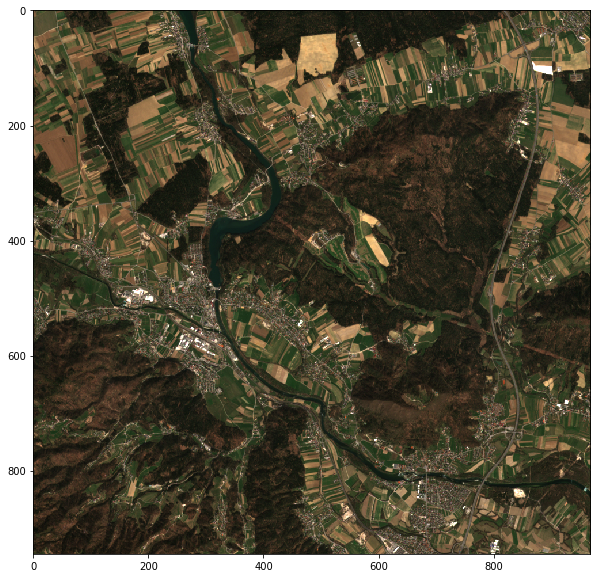

In [706]:
image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 255)
# mask = np.squeeze(eopatch.mask_timeless['LPIS_sifra'])

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image)

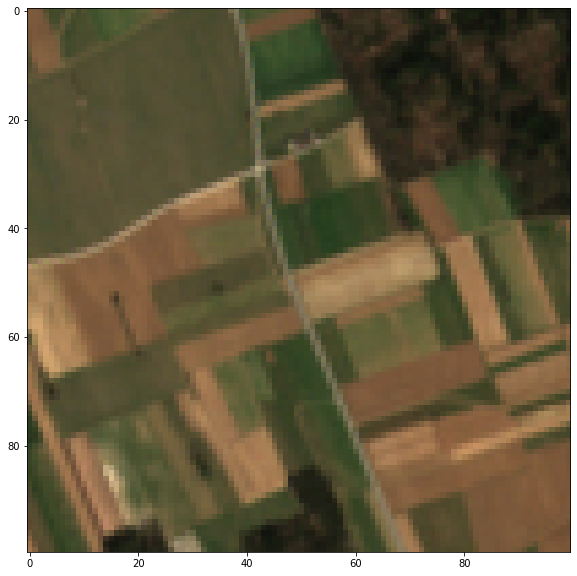

In [708]:
fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image[:100, :100])

In [304]:
image[700:800, 250:350].shape

(100, 100, 3)

In [50]:
eopatch_after_sampling = EOPatch.load('/Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days/' + DATA_LIST[1])
eopatch_after_sampling

/Users/markbogataj/.local/lib/python3.6/site-packages/eolearn/core/eodata.py:75: DeprecationWarning: FeatureType.MASK_TIMELESS is a discrete feature type therefore dtype of data should be a subtype of numpy.integer or numpy.bool, found type <class 'numpy.float64'>. In the future an error will be raised becauseof this
  self[key][feature_name] = value


EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(34, 10822, 1, 7), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(10822, 100, 1), dtype=float64)
    LPIS_multi_grouped_crops: numpy.ndarray(shape=(10822, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(10822, 1, 1), dtype=int64)
    PID: numpy.ndarray(shape=(10822, 1, 1), dtype=uint32)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((451581.91665190033, 5105816.813818144), (461269.3104915918, 5115262.978997778)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2017, 1, 1, 0, 0), ..., datetime.datetime(2017, 9, 22, 0, 0)], length=34
)

In [237]:
img = eopatch.data['BANDS-S2-L2A'][10].copy()

for i in range(0, len(f[0])):
    img[f[0][i]][f[1][i]][1] = 1
    img[f[0][i]][f[1][i]][2] = 0
    img[f[0][i]][f[1][i]][3] = 0

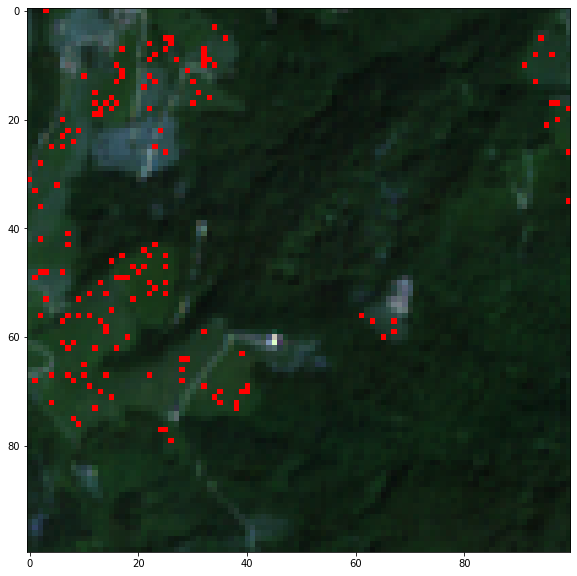

In [238]:
# img2 = np.clip(img[2, 1, 0])

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(np.clip(img[:100, :100, 1:4] *3.5, 0, 1))
fig.savefig('sampling.png', pad_inches=0)

In [231]:
f = np.load('/Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days/' + DATA_LIST[1] + 'sampling.npy')

ERROR! Session/line number was not unique in database. History logging moved to new session 385


In [784]:
ptch_after = EOPatch.load('/Volumes/Seagate_drive/custom-patch/eopatch_101_col-8_row-8')
ptch_after

ERROR! Session/line number was not unique in database. History logging moved to new session 429


EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(34, 945, 969, 7), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_multi_grouped_crops: numpy.ndarray(shape=(9450, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=int64)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((451581.91665190033, 5105816.813818144), (461269.3104915918, 5115262.978997778)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2017, 1, 1, 0, 0), ..., datetime.datetime(2017, 9, 22, 0, 0)], length=34
)

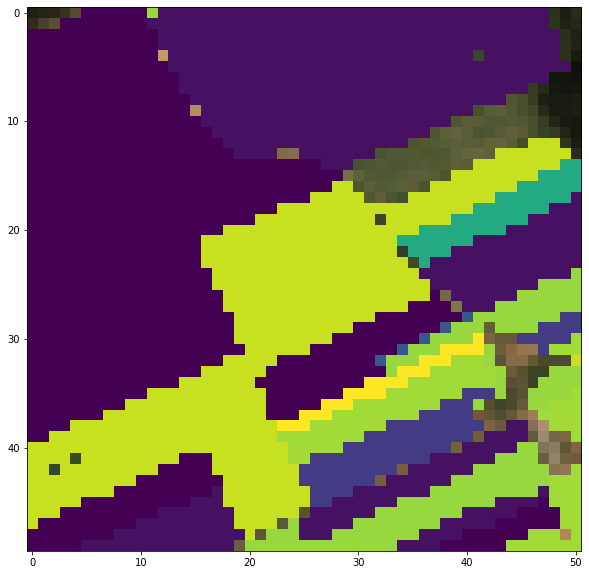

In [801]:
image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)
maks = np.squeeze(eopatch.mask_timeless['LPIS_sifra'])

# for i in range(0, 50):
#     for j in range(0 ,100):
#         if(np.isnan(eopatch['mask_timeless']['LPIS_sifra'][i+170][j+200])):
#             continue
#         elif(ptch_after['mask_timeless']['LPIS_sifra'][i+170][j+200] <= 0):
#             continue
#         else:
#             image[i+170,j+200,0] = 0
#             image[i+170,j+200,1] = 1
#             image[i+170,j+200,2] = 0
            
fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image[150:200, 200:251])
ax0.imshow(maks[150:200, 200:251])

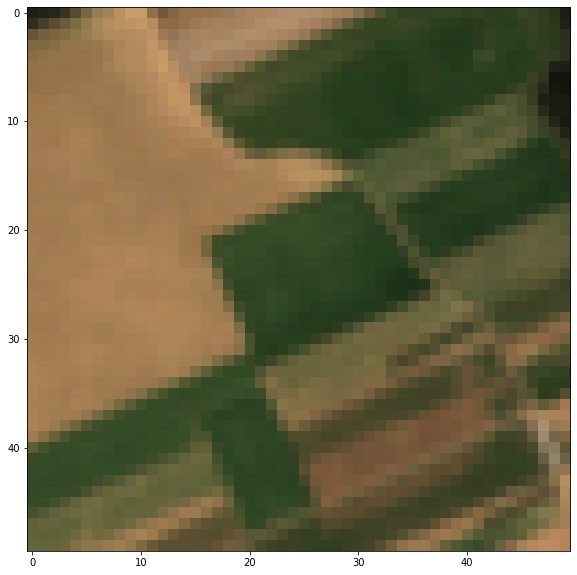

In [820]:
image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)
fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image[150:200, 200:250])
# fig.savefig('raw_img_ppt.png', pad_inches=0)

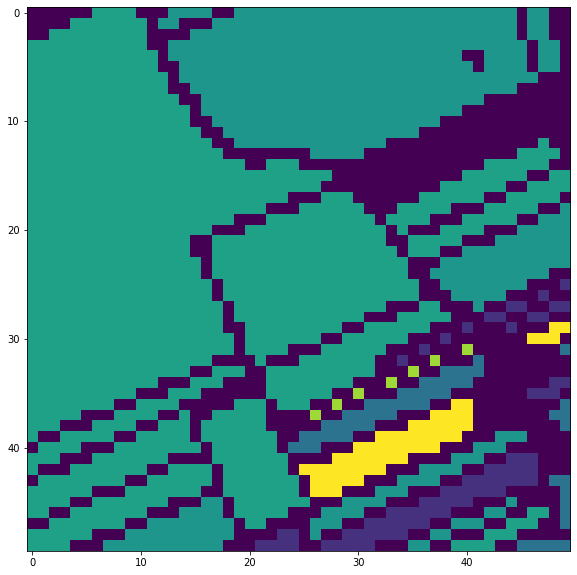

In [821]:
image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)
mask = np.squeeze(ptch_after.mask_timeless['LPIS_sifra'])

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image[150:200, 200:250])
ax0.imshow(mask[150:200, 200:250], alpha=1)
# fig.savefig('raw_img_w_mask_ppt.png', pad_inches=0)

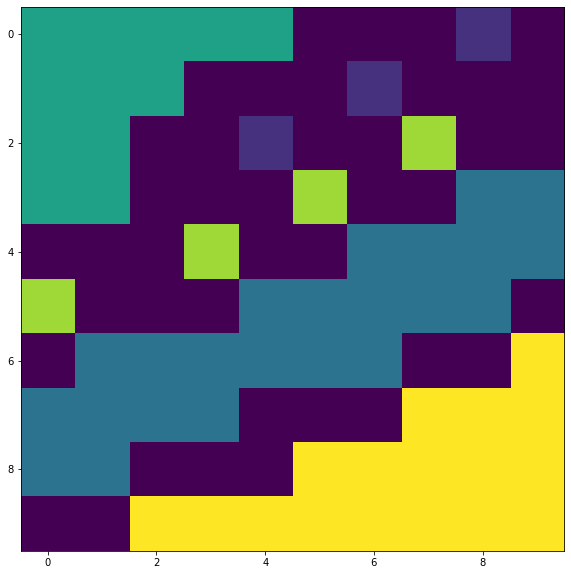

In [822]:
image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)
mask = np.squeeze(ptch_after.mask_timeless['LPIS_sifra'])

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image[180:190, 230:240])
ax0.imshow(mask[180:190, 230:240], alpha=1)
# fig.savefig('raw_img_w_mask_zoom_ppt.png', pad_inches=0)

10

ERROR! Session/line number was not unique in database. History logging moved to new session 427


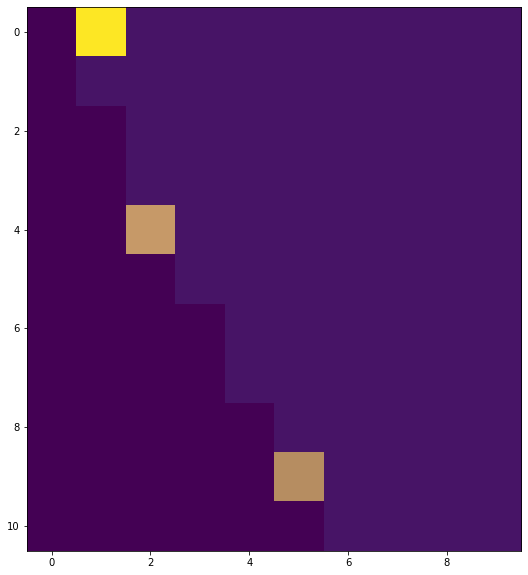

In [763]:
image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)
mask = np.squeeze(eopatch.mask_timeless['LPIS_sifra'])

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image[150:161, 210:220])
ax0.imshow(mask[150:161, 210:220], alpha=1)

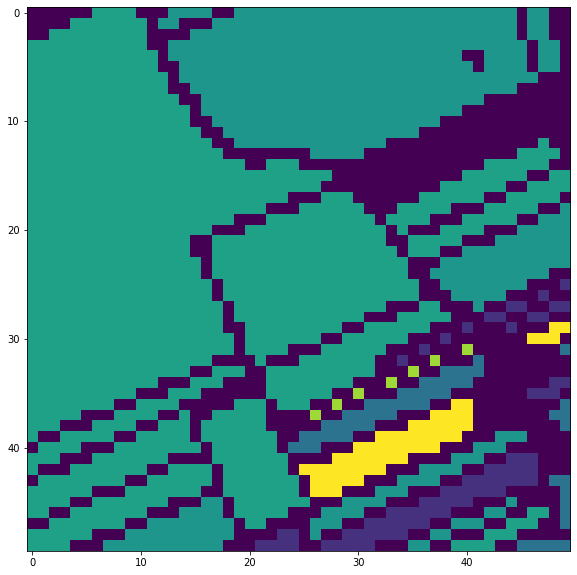

In [795]:
image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)
mask = np.squeeze(ptch_after.mask_timeless['LPIS_sifra'])

# for i in range(150, 200):
#     for j in range(200, 250):
#         if(mask[i][j] == 0 or mask[i][j] == 23):
#             mask[i][j] = -1
            
fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image[150:200, 200:250])
ax0.imshow(mask[150:200, 200:250], alpha=1)

# print(mask[150:200, 200:250])

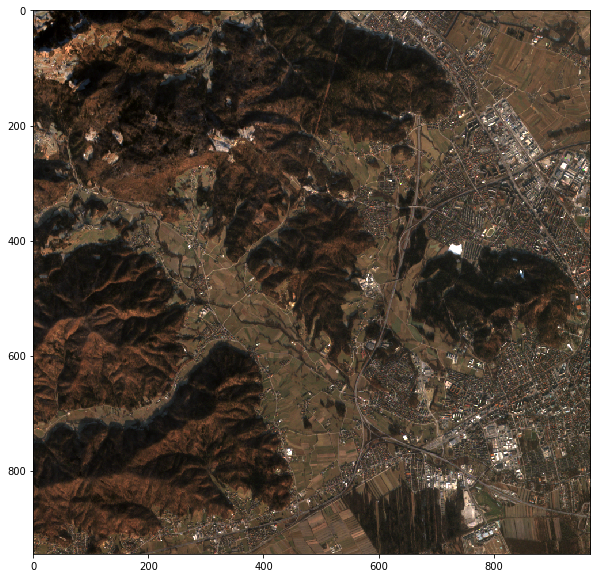

In [37]:
image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)
# mask = np.squeeze(eopatch.mask_timeless['LPIS_sifra'])

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image)
# ax0.imshow(mask, alpha=0.5)

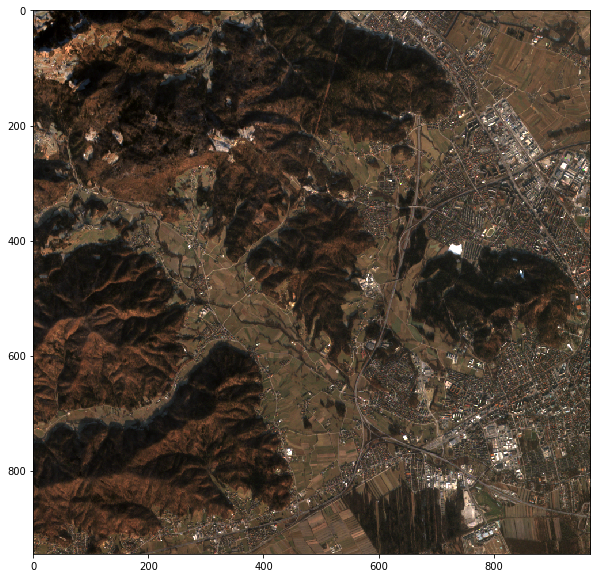

In [38]:
image = np.clip(eopatch.data['BANDS-S2-L2A'][1][..., [3, 2, 1]] * 3.5, 0, 1)

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image)

In [278]:
# np.unique(eopatch.mask_timeless['LPIS_sifra'])
c = 0
for i in range(0, ptch.mask_timeless['LPIS_sifra'].shape[0]):
    for j in range(0, ptch.mask_timeless['LPIS_sifra'].shape[1]):
        if(ptch.mask_timeless['LPIS_sifra'][i][j] > 0):
            c = c + 1
print(c)

ERROR! Session/line number was not unique in database. History logging moved to new session 389
915705


(945, 969, 1)

In [639]:
ptch = EOPatch.load('/Volumes/Seagate_drive/custom-patch/eopatch_101_col-8_row-8')
ptch

EOPatch(
  data: {
    FEATURES: numpy.ndarray(shape=(34, 945, 969, 7), dtype=float64)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LPIS_multi: numpy.ndarray(shape=(9450, 9690, 1), dtype=uint16)
    LPIS_multi_grouped_crops: numpy.ndarray(shape=(9450, 100, 1), dtype=float64)
    LPIS_sifra: numpy.ndarray(shape=(945, 969, 1), dtype=int64)
    PID: numpy.ndarray(shape=(945, 969, 1), dtype=uint32)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((451581.91665190033, 5105816.813818144), (461269.3104915918, 5115262.978997778)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2017, 1, 1, 0, 0), ..., datetime.datetime(2017, 9, 22, 0, 0)], length=34
)

In [395]:
np.unique(ptch.mask_timeless['LPIS_multi'])

array([  0,   1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  20,  26,
        27,  30,  33,  36,  42, 101, 201, 203, 204, 206, 207, 208, 219,
       222, 402, 405, 409, 651, 659, 678, 699, 703, 735, 801, 802, 803,
       807, 809, 814], dtype=uint16)

In [49]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(ptch.data['FEATURES'][20][..., [2, 1, 0]] * 3.5, 0, 1))

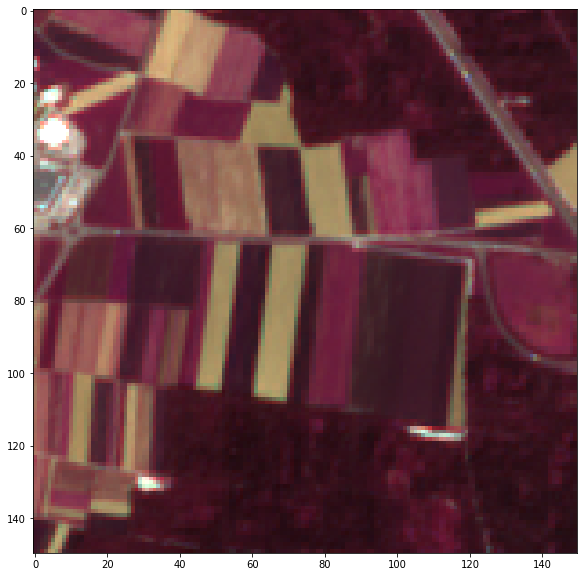

In [566]:
image = np.clip(ptch.data['FEATURES'][25][..., [2, 1, 0]] * 3.5, 0, 1)

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(image[300:450, 50:200])
# fig.savefig('out.png', pad_inches=0)

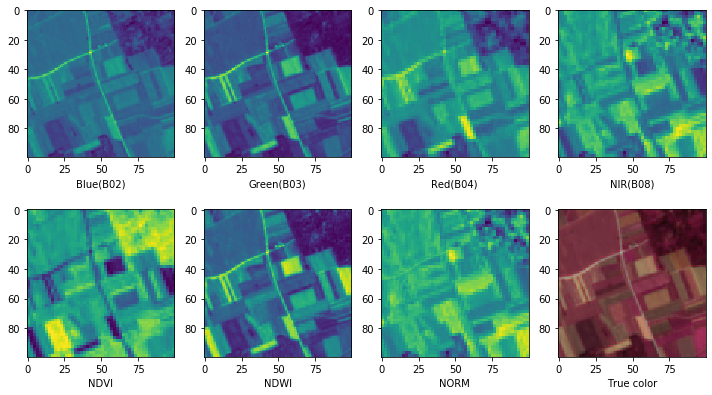

In [230]:
# image = np.clip(ptch.data['FEATURES'][20][..., [0]] * 3.5, 0, 1)

sloj_1 = np.zeros((100,100))
sloj_2 = np.zeros((100,100))
sloj_3 = np.zeros((100,100))
sloj_4 = np.zeros((100,100))
sloj_5 = np.zeros((100,100))
sloj_6 = np.zeros((100,100))
sloj_7 = np.zeros((100,100))
sloj_true = np.clip(ptch.data['FEATURES'][20][..., [2, 1, 0]] * 3.5, 0, 1)

for i in range(0, 100):
    for j in range(0, 100):
        sloj_1[i][j] = ptch.data['FEATURES'][20][i][j][0]
        sloj_2[i][j] = ptch.data['FEATURES'][20][i][j][1]
        sloj_3[i][j] = ptch.data['FEATURES'][20][i][j][2]
        sloj_4[i][j] = ptch.data['FEATURES'][20][i][j][3]
        sloj_5[i][j] = ptch.data['FEATURES'][20][i][j][4]
        sloj_6[i][j] = ptch.data['FEATURES'][20][i][j][5]
        sloj_7[i][j] = ptch.data['FEATURES'][20][i][j][6]
        
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(2, 4, 1)
plt.imshow(sloj_1)
plt.xlabel('Blue(B02)')

fig.add_subplot(2, 4, 2)
plt.imshow(sloj_2)
plt.xlabel('Green(B03)')

fig.add_subplot(2, 4, 3)
plt.imshow(sloj_3)
plt.xlabel('Red(B04)')

fig.add_subplot(2, 4, 4)
plt.imshow(sloj_4)
plt.xlabel('NIR(B08)')

fig.add_subplot(2, 4, 5)
plt.imshow(sloj_5)
plt.xlabel('NDVI')

fig.add_subplot(2, 4, 6)
plt.imshow(sloj_6)
plt.xlabel('NDWI')

fig.add_subplot(2, 4, 7)
plt.imshow(sloj_7)
plt.xlabel('NORM')

fig.add_subplot(2, 4, 8)
plt.imshow(sloj_true[:100, :100])
plt.xlabel('True color')

plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=-0.6)

# fig.savefig('band_presentation.png', pad_inches=0)

In [53]:
ptch.mask_timeless['LPIS_sifra'].shape

(945, 969, 1)

ERROR! Session/line number was not unique in database. History logging moved to new session 359


In [640]:
predikcije_all_data_ones_in = np.load('./predikcije-za-slike/predikcije_all_data_ones.npy')
predikcije_all_data_percentage_in = np.load('./predikcije-za-slike/predikcije_all_data_percentage.npy')
predikcije_eq_data_ones_in = np.load('./predikcije-za-slike/predikcije_eq_data_ones.npy')
predikcije_eq_data_percentage_in = np.load('./predikcije-za-slike/predikcije_eq_data_percentage.npy')

print(predikcije_all_data_ones_in.shape)
print(predikcije_all_data_percentage_in.shape)
print(predikcije_eq_data_ones_in.shape)
print(predikcije_eq_data_percentage_in.shape)

(6077, 26)
(6077, 26)
(6077, 26)
(6077, 26)


In [320]:
np.where(predikcije_all_data_ones[0] == np.amax(predikcije_all_data_ones[0]))[0][0]

0

In [641]:
predikcije_all_data_ones = []
predikcije_all_data_percentage = []
predikcije_eq_data_ones = []
predikcije_eq_data_percentage = []

for i in range(0, len(predikcije_all_data_ones_in)):
    predikcije_all_data_ones.append(np.where(predikcije_all_data_ones_in[i] == np.amax(predikcije_all_data_ones_in[i]))[0][0])
    predikcije_all_data_percentage.append(np.where(predikcije_all_data_percentage_in[i] == np.amax(predikcije_all_data_percentage_in[i]))[0][0])
    predikcije_eq_data_ones.append(np.where(predikcije_eq_data_ones_in[i] == np.amax(predikcije_eq_data_ones_in[i]))[0][0])
    predikcije_eq_data_percentage.append(np.where(predikcije_eq_data_percentage_in[i] == np.amax(predikcije_eq_data_percentage_in[i]))[0][0])

print(len(predikcije_all_data_ones))
print(len(predikcije_all_data_percentage))
print(len(predikcije_eq_data_ones))
print(len(predikcije_eq_data_percentage))

6077
6077
6077
6077


In [642]:
maska_all_ones = np.zeros((100, 100))
maska_all_percentage = np.zeros((100, 100))
maska_eq_ones = np.zeros((100, 100))
maska_eq_percentage = np.zeros((100, 100))

c = 0
# [300:450, 50:200]
for i in range(0, 100):
    for j in range(0, 100):
        if(ptch.mask_timeless['LPIS_sifra'][i][j][0] != 23):
            maska_all_ones[i][j] = predikcije_all_data_ones[c]
            maska_all_percentage[i][j] = predikcije_all_data_percentage[c]
            maska_eq_ones[i][j] = predikcije_eq_data_ones[c]
            maska_eq_percentage[i][j] = predikcije_eq_data_percentage[c]
            
            c = c + 1
print(c)

6077


In [643]:
maska_gt = np.zeros((100, 100))

for i in range(0, 100):
    for j in range(0, 100):
        if(ptch.mask_timeless['LPIS_sifra'][i][j][0] != 23):
            maska_gt[i][j] = ptch.mask_timeless['LPIS_sifra'][i][j][0]

In [483]:
# barve[:, 0:5] = 0.0
# barve[:, 6:10] = 0.07
# barve[:, 11:15] = 0.14
# barve[:, 16:20] = 0.21
# barve[:, 21:25] = 0.28
# barve[:, 26:30] = 0.35
# barve[:, 31:35] = 0.42
# barve[:, 36:40] = 0.49
# barve[:, 41:45] = 0.56
# barve[:, 46:50] = 0.63
# barve[:, 51:55] = 0.70
# barve[:, 56:60] = 0.77
# barve[:, 61:65] = 0.84
# barve[:, 66:70] = 0.91
# barve[:, 71:75] = 0.98

# [1,3,4,5,8,14,16,18,19,21]
def enotno_pobarvaj(tab):
    rez = np.zeros((len(tab), len(tab[0])))
    
    for i in range(0, len(tab)):
        for j in range(0, len(tab[0])):
            if(tab[i][j] == 2):
                rez[i][j] = 0.07
            elif(tab[i][j] == 6):
                rez[i][j] = 0.14
            elif(tab[i][j] == 7):
                rez[i][j] = 0.21
            elif(tab[i][j] == 9):
                rez[i][j] = 0.28
            elif(tab[i][j] == 10):
                rez[i][j] = 0.35
            elif(tab[i][j] == 11):
                rez[i][j] = 0.42
            elif(tab[i][j] == 12):
                rez[i][j] = 0.49
            elif(tab[i][j] == 13):
                rez[i][j] = 0.56
            elif(tab[i][j] == 15):
                rez[i][j] = 0.63
            elif(tab[i][j] == 17):
                rez[i][j] = 0.70
            elif(tab[i][j] == 20):
                rez[i][j] = 0.77
            elif(tab[i][j] == 22):
                rez[i][j] = 0.84
            elif(tab[i][j] == 24):
                rez[i][j] = 0.91
            elif(tab[i][j] == 25):
                rez[i][j] = 0.98
    return rez

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


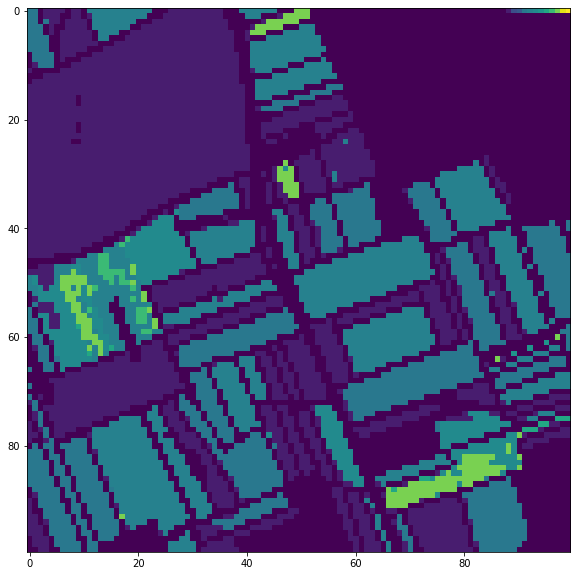

In [671]:
%matplotlib inline

k = maska_all_ones
k[0][88]=2
k[0][89]=6
k[0][90]=7
k[0][91]=10
k[0][92]=11
k[0][93]=12
k[0][94]=13
k[0][95]=15
k[0][96]=17
k[0][97]=20
k[0][98]=24
k[0][99]=25
# # k[149][144]=2
# # k[149][145]=2
# i = enotno_pobarvaj(k)

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(k)
fig.savefig('maska_all_ones.png', pad_inches=0)

In [659]:
# print(maska_all_ones[130][10])
print(np.unique(maska_all_ones))

[ 0.  2. 10. 11. 12. 13. 15. 17. 20.]


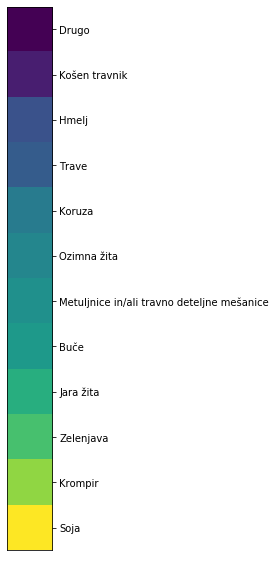

In [673]:
legenda = np.zeros((12,1))

# legenda[0][0]=0
# legenda[1][0]=2
# legenda[2][0]=6
# legenda[3][0]=7
# legenda[4][0]=9
# legenda[5][0]=10
# legenda[6][0]=11
# legenda[7][0]=12
# legenda[8][0]=13
# legenda[9][0]=15
# legenda[10][0]=17
# legenda[11][0]=20
# legenda[12][0]=22
# legenda[13][0]=24
# legenda[14][0]=25
legenda[0][0]=0
legenda[1][0]=2
legenda[2][0]=6
legenda[3][0]=7
legenda[4][0]=10
legenda[5][0]=11
legenda[6][0]=12
legenda[7][0]=13
legenda[8][0]=15
legenda[9][0]=17
legenda[10][0]=20
legenda[11][0]=24
# legenda[12][0]=25

x_lab = [0,1,2,3,4,5,6,7,8,9,10,11]
# y_lab = ['Drugo','Košen travnik','Hmelj','Trave','Ozimna oljna ogrščica','Koruza','Ozimna žita',
#          'Metuljnice in/ali travno deteljne mešanice','Buče','Jara žita','Zelenjava','Krompir',
#          'Vinogradi','Soja','Sadno drevje']
y_lab = ['Drugo','Košen travnik','Hmelj','Trave','Koruza','Ozimna žita',
         'Metuljnice in/ali travno deteljne mešanice','Buče','Jara žita',
         'Zelenjava','Krompir','Soja']
fig, ax0 = plt.subplots(figsize=(10, 10))
plt.yticks(x_lab, y_lab)
plt.xticks([], [])
ax0.yaxis.set_ticks_position("right")
ax0.imshow(legenda)
# fig.savefig('legenda_slike1_f.png', pad_inches=0)

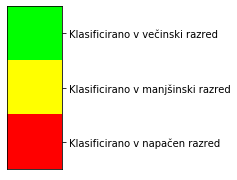

In [691]:
legenda = np.zeros((3,1,3))
legenda[0][0][0]=0
legenda[0][0][1]=255
legenda[0][0][2]=0
legenda[1][0][0]=255
legenda[1][0][1]=255
legenda[1][0][2]=0
legenda[2][0][0]=255
legenda[2][0][1]=0
legenda[2][0][2]=0

x_lab = [0,1,2]
y_lab = ['Klasificirano v večinski razred',
         'Klasificirano v manjšinski razred',
         'Klasificirano v napačen razred']
fig, ax0 = plt.subplots(figsize=(3, 3))
plt.yticks(x_lab, y_lab)
plt.xticks([], [])
ax0.yaxis.set_ticks_position("right")
ax0.imshow(legenda)
fig.savefig('legenda_z_r_r.png', bbox_inches='tight', pad_inches=0.5)

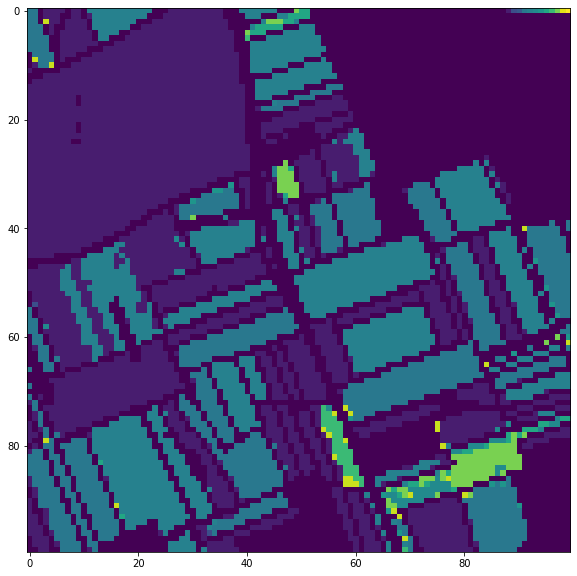

In [669]:
k = maska_all_percentage
k[0][88]=2
k[0][89]=6
k[0][90]=7
k[0][91]=10
k[0][92]=11
k[0][93]=12
k[0][94]=13
k[0][95]=15
k[0][96]=17
k[0][97]=20
k[0][98]=24
k[0][99]=25
# # k[149][144]=2
# # k[149][145]=2
# i = enotno_pobarvaj(k)

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(k)
fig.savefig('maska_all_percentage.png', pad_inches=0)

In [658]:
# print(maska_all_percentage[130][10])
print(np.unique(maska_all_percentage))

[ 0.  2.  6. 10. 11. 12. 13. 15. 17. 20. 23.]


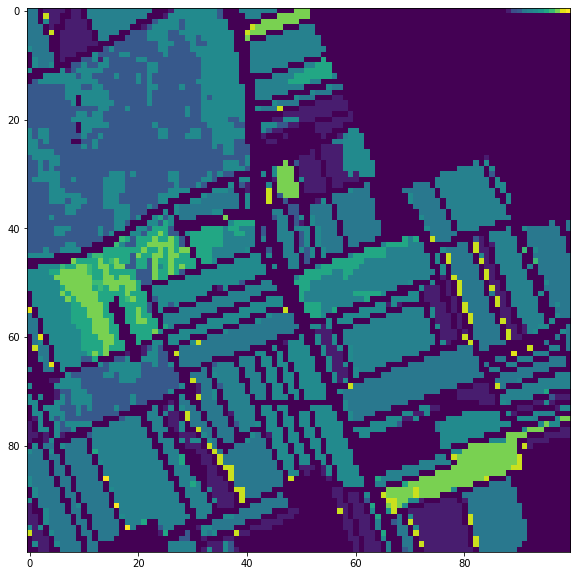

In [668]:
k = maska_eq_ones
k[0][88]=2
k[0][89]=6
k[0][90]=7
k[0][91]=10
k[0][92]=11
k[0][93]=12
k[0][94]=13
k[0][95]=15
k[0][96]=17
k[0][97]=20
k[0][98]=24
k[0][99]=25
# # k[149][144]=2
# # k[149][145]=2
# i = enotno_pobarvaj(k)

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(k)
fig.savefig('maska_eq_ones.png', pad_inches=0)

In [657]:
# print(maska_eq_ones[129][10])
print(np.unique(maska_eq_ones))

[ 0.  2.  7. 10. 11. 12. 13. 15. 17. 20. 23. 24. 25.]


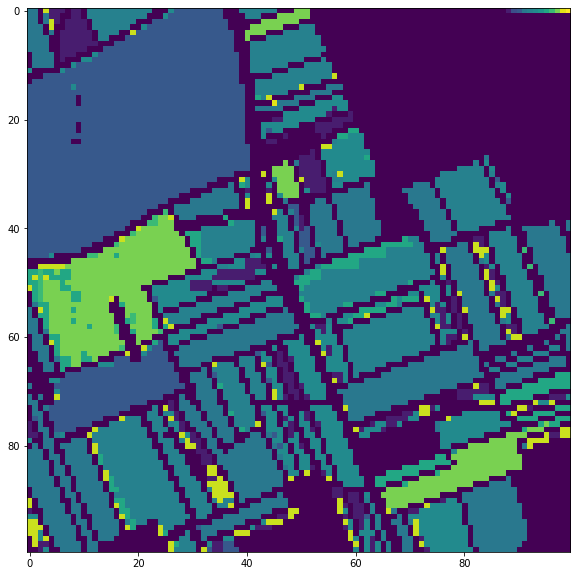

In [667]:
k = maska_eq_percentage
k[0][88]=2
k[0][89]=6
k[0][90]=7
k[0][91]=10
k[0][92]=11
k[0][93]=12
k[0][94]=13
k[0][95]=15
k[0][96]=17
k[0][97]=20
k[0][98]=24
k[0][99]=25
# i = enotno_pobarvaj(k)

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(k)
fig.savefig('maska_eq_percentage.png', pad_inches=0)

In [655]:
# print(maska_eq_percentage[130][10])
print(np.unique(maska_eq_percentage))

[ 0.  2.  7. 10. 11. 12. 15. 17. 20. 23. 24.]


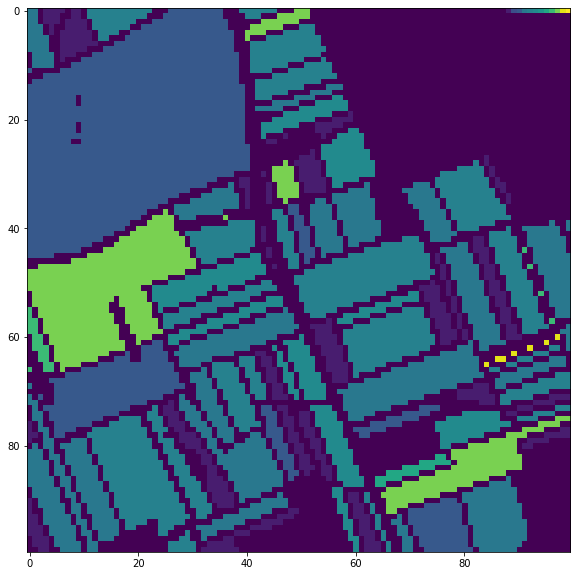

In [666]:
k = maska_gt
k[0][88]=2
k[0][89]=6
k[0][90]=7
k[0][91]=10
k[0][92]=11
k[0][93]=12
k[0][94]=13
k[0][95]=15
k[0][96]=17
k[0][97]=20
k[0][98]=24
k[0][99]=25
# # k[149][144]=2
# # k[149][145]=2
# i = enotno_pobarvaj(k)

fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(k)
fig.savefig('maska_gt.png', pad_inches=0)

In [674]:
print(maska_gt[20][20])
print(np.unique(maska_gt))

7.0
[ 0.  2.  6.  7. 10. 11. 12. 13. 15. 17. 20. 24. 25.]


In [299]:
# [ 0.  2.        10. 11. 12. 13. 15. 17. 20.]
# [ 0.  2.  6.    10. 11. 12. 13. 15. 17. 20. 23.]
# [ 0.  2.     7. 10. 11. 12. 13. 15. 17. 20. 23. 24. 25.]
# [ 0.  2.     7. 10. 11. 12.     15. 17. 20. 23. 24.]
# [ 0.  2.     7. 10. 11. 12.     15. 17. 20.     24.]

ERROR! Session/line number was not unique in database. History logging moved to new session 396


In [287]:
def crops_to_groups_multi(in_eopatch):
    # group definition 
    beets1_set = [101, 19]
    meadows2_set = [204]
    fallow_land3_set = [26]
    peas4_set = [44, 33, 833]
    pasture5_set = []
    hop6_set = [900]
    grass7_set = [118, 505, 201, 200, 202, 117]
    poppy8_set = [31, 831]
    winter_rape9_set = [812, 814]
    maize10_set = [6, 5, 109, 49]
    winter_cereals11_set = [809, 808, 803, 801, 802, 24, 825, 807]
    leafy_legumes12_set = [220, 207, 206, 219, 211, 222, 208, 223, 221, 203]
    pumpkins13_set = [42, 13]
    soft_fruits14_set = [652, 681, 657, 679, 656, 660, 659, 651, 653, 655, 662, 654, 678]
    summer_cereals15_set = [9, 11, 811, 8, 3, 10, 1, 2, 25, 7]
    sunflower16_set = [12]
    vegetables17_set = [46, 47, 48, 402]
    buckwheat18_set = [4]
    alpine_meadows19_set = []
    potatoes20_set = [20]
    beans21_set = [45, 17]
    vineyards22_set = [707, 661, 706, 100]
    other23_set = [115, 37, 738, 733, 648, 32, 111, 646, 555, 43, 675, 702, 114, 721, 619, 615, 110, 810,
                720, 35, 835, 27, 112, 102, 104, 804, 105, 106, 107, 28, 40, 41, 405, 710, 699, 705, 409,
                506, 722, 999, 904, '204_a', 0, 888, 404, 735, 14, 113, 103, 108, 777, 734, 649, 403, 36,
                34, 998, 737, 677, 21, 821, 116, 680, 703, 333, 723, 704, 29, 210, 736]
    soybean24_set = [30]
    orchards25_set = [621, 625, 672, 612, 611, 627, 643, 642, 676, 644, 613, 632, 671, 674, 633, 624, 658,
                614, 622, 616, 800, 631, 698, 673, 623, 647, 626, 618]
    
    tmp_patch = in_eopatch.__copy__()
    x = tmp_patch['mask_timeless']['LPIS_multi'].shape[0]
    y = tmp_patch['mask_timeless']['LPIS_multi'].shape[1]
    out_arr = np.zeros((1000, 1000, 1))
    for i in range(7000, 8000):
        for j in range(2500, 3500):
            val = tmp_patch['mask_timeless']['LPIS_multi'][i][j][0]

            if(val in beets1_set):
                out_arr[i-7000][j-2500][0] = 1
            elif(val in meadows2_set):
                out_arr[i-7000][j-2500][0] = 2
            elif(val in fallow_land3_set):
                out_arr[i-7000][j-2500][0] = 3
            elif(val in peas4_set):
                out_arr[i-7000][j-2500][0] = 4
            elif(val in pasture5_set):
                out_arr[i-7000][j-2500][0] = 5
            elif(val in hop6_set):
                out_arr[i-7000][j-2500][0] = 6
            elif(val in grass7_set):
                out_arr[i-7000][j-2500][0] = 7
            elif(val in poppy8_set):
                out_arr[i-7000][j-2500][0] = 8
            elif(val in winter_rape9_set):
                out_arr[i-7000][j-2500][0] = 9
            elif(val in maize10_set):
                out_arr[i-7000][j-2500][0] = 10
            elif(val in winter_cereals11_set):
                out_arr[i-7000][j-2500][0] = 11
            elif(val in leafy_legumes12_set):
                out_arr[i-7000][j-2500][0] = 12
            elif(val in pumpkins13_set):
                out_arr[i-7000][j-2500][0] = 13
            elif(val in soft_fruits14_set):
                out_arr[i-7000][j-2500][0] = 14
            elif(val in summer_cereals15_set):
                out_arr[i-7000][j-2500][0] = 15
            elif(val in sunflower16_set):
                out_arr[i-7000][j-2500][0] = 16
            elif(val in vegetables17_set):
                out_arr[i-7000][j-2500][0] = 17
            elif(val in buckwheat18_set):
                out_arr[i-7000][j-2500][0] = 18
            elif(val in alpine_meadows19_set):
                out_arr[i-7000][j-2500][0] = 19
            elif(val in potatoes20_set):
                out_arr[i-7000][j-2500][0] = 20
            elif(val in beans21_set):
                out_arr[i-7000][j-2500][0] = 21
            elif(val in vineyards22_set):
                out_arr[i-7000][j-2500][0] = 22
            elif(val in other23_set):
                out_arr[i-7000][j-2500][0] = 23
            elif(val in soybean24_set):
                out_arr[i-7000][j-2500][0] = 24
            elif(val in orchards25_set):
                out_arr[i-7000][j-2500][0] = 25
            else:
                print('CROP GROUP NOT FOUND: ',tmp_patch['mask_timeless']['LPIS_multi'][i][j][0])
                
    return out_arr

In [288]:
arr = crops_to_groups_multi(ptch)

In [289]:
np.unique(arr)

array([ 2.,  7., 10., 11., 12., 15., 17., 20., 23.])

In [124]:
multi_data = np.zeros((100, 100, 26))

for i in range(0, 100):
    for j in range(0, 100):
        
        for m in range(0, 10):
            for n in range(0, 10):
                multi_data[i][j][int(arr[(i * 10) + m][(j * 10) + n][0])] = multi_data[i][j][int(arr[(i * 10) + m][(j * 10) + n][0])] + 0.01

In [125]:
multi_data[0][1]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.52,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.48, 0.  , 0.  ])

In [129]:
list_vec_razrednih_celic = []
list_vec_razrednih_celic_X = []
for i in range(700, 800):
    for j in range(0, 100):
        c = 0
        for k in range(0, 26):
            if(multi_data[i][j][k] > 0):
                c = c + 1
        if(c > 1):
            list_vec_razrednih_celic_X.append(ptch.data['FEATURES'][:, i, j, :])
            list_vec_razrednih_celic.append(multi_data[i][j])

ERROR! Session/line number was not unique in database. History logging moved to new session 370


In [131]:
print(len(list_vec_razrednih_celic))
print(len(list_vec_razrednih_celic_X))
np.save('./list_vec_razrednih_celic.npy', list_vec_razrednih_celic)
np.save('./list_vec_razrednih_celic_X.npy', list_vec_razrednih_celic_X)

3440
3440


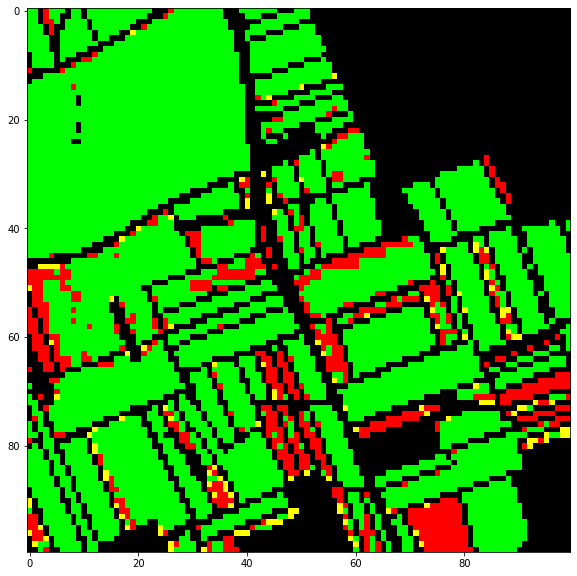

In [146]:
maska_test = np.zeros((100, 100, 3))

c = 0

for i in range(0, 100):
    for j in range(0, 100):
        if(ptch.mask_timeless['LPIS_sifra'][i][j][0] != 23):
            
            idx_napoved = np.where(predikcije_eq_data_percentage_in[c] == np.amax(predikcije_eq_data_percentage_in[c]))[0][0]
            
            list_razredov = []
            for k in range(0, 26):
                if(multi_data[i][j][k] > 0):
                    list_razredov.append(k)
            
            if(idx_napoved == ptch.mask_timeless['LPIS_sifra'][i][j][0]):
                maska_test[i][j][0] = 0
                maska_test[i][j][1] = 255
                maska_test[i][j][2] = 0
            elif(idx_napoved in list_razredov):
                maska_test[i][j][0] = 255
                maska_test[i][j][1] = 255
                maska_test[i][j][2] = 0
            else:
                maska_test[i][j][0] = 255
                maska_test[i][j][1] = 0
                maska_test[i][j][2] = 0
            
            c = c +1
            
fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(maska_test)
# fig.savefig('maska_eq_percentage_z_r_r.png', pad_inches=0)


In [136]:
multi_data.shape

(100, 100, 26)

In [137]:
predikcije_eq_data_percentage_in.shape

(6077, 26)

In [167]:
list_of_cells = []
list_of_groundtruth = []

list_of_all_LPIS_data = []

for idx in range(0, len(DATA_LIST)):
    
    if(DATA_LIST[idx] == '.DS_Store'):
        continue
    else:
#         eopatch = EOPatch.load(os.path.join('/Volumes/Seagate_drive/aFractionIndices1_05/interpolation-8days', DATA_LIST[idx]))
        eopatch = EOPatch.load(os.path.join('/Volumes/Seagate_drive/custom-patch', DATA_LIST[idx]))

        lpis_data_arr = eopatch.mask_timeless['LPIS_sifra'].copy()


        for k in range(0, lpis_data_arr.shape[0]):
            for j in range(0, lpis_data_arr.shape[1]):
                list_of_all_LPIS_data.append([lpis_data_arr[i][j][0]])
            
print(len(list_of_all_LPIS_data))

ERROR! Session/line number was not unique in database. History logging moved to new session 371
8241345


In [170]:
array_LPIS_data = np.array(list_of_all_LPIS_data) 

array_LPIS_data = []
for i in range(0, len(list_of_all_LPIS_data)):
    array_LPIS_data.append(list_of_all_LPIS_data[i][0])

[[x,(array_LPIS_data.count(x))] for x in set(array_LPIS_data)]


# drop_classes = [1,3,4,5,8,14,16,18,19,21]
# [2, 823095],
# [4, 3780],
# [7, 59535],
# [9, 5670],
# [10, 378945],
# [11, 231525],
# [12, 156870],
# [13, 945],
# [15, 27405],
# [17, 18900],
# [20, 13230],
# [23, 6495930],
# [24, 8505],
# [25, 6615]

[[2, 823095],
 [4, 3780],
 [7, 59535],
 [9, 5670],
 [10, 378945],
 [11, 231525],
 [12, 156870],
 [13, 945],
 [15, 27405],
 [17, 18900],
 [18, 10395],
 [20, 13230],
 [23, 6495930],
 [24, 8505],
 [25, 6615]]

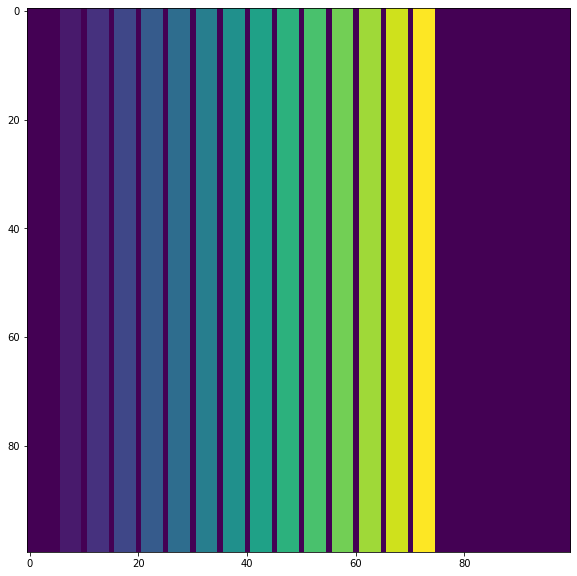

In [431]:
barve = np.zeros((100,100))
barve[:, 0:5] = 0.0
barve[:, 6:10] = 0.07
barve[:, 11:15] = 0.14
barve[:, 16:20] = 0.21
barve[:, 21:25] = 0.28
barve[:, 26:30] = 0.35
barve[:, 31:35] = 0.42
barve[:, 36:40] = 0.49
barve[:, 41:45] = 0.56
barve[:, 46:50] = 0.63
barve[:, 51:55] = 0.70
barve[:, 56:60] = 0.77
barve[:, 61:65] = 0.84
barve[:, 66:70] = 0.91
barve[:, 71:75] = 0.9
# barve[:, 76:80] = 0.75
# barve[:, 81:85] = 0.80
# barve[:, 86:90] = 0.85
# barve[:, 91:95] = 0.90
# barve[:, 96:100] = 0.95
fig, ax0 = plt.subplots(figsize=(10, 10))
ax0.imshow(barve)